In [43]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install webrtcvad --user

  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 71kB 863kB/s ta 0:00:01
  Running setup.py bdist_wheel for webrtcvad ... done
  Stored in directory: /home/mpc6/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
Successfully built webrtcvad
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [311]:
import os
import soundfile as sf
#import sounddevice as sd
#import librosa
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
import thinkdsp
import subprocess
from sklearn.model_selection import train_test_split
# Keras packages model
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Convolution2D, Dropout, BatchNormalization, Flatten, concatenate
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping

SAMPLERATE = 8000
DATAPATH = 'data'
MINSIZE = 2000
MAXSIZE = 4500

In [82]:
# Download raw data from source
os.makedirs(DATAPATH, exist_ok=True)

url = 'http://www.dive-into.info/7577'
zips = ['numbers.zip', 'moreNumbers.zip']

for zipFile in zips:
    if os.path.exists(zipFile):
        os.remove(zipFile)
        
    get_url = os.path.join(url, zipFile)
    print('Downloading', zipFile)
    rtnVal = subprocess.call(['wget', get_url])
    print(zipFile, 'downloaded successfully')

    print('Unzipping', zipFile)
    rtnVal = subprocess.call(['unzip', zipFile, '-d', dataDir])
    print(zipFile, 'unzipped successfully')



numbers.zip downloaded successfully
Unzipping numbers.zip
numbers.zip unzipped successfully
moreNumbers.zip downloaded successfully
Unzipping moreNumbers.zip
moreNumbers.zip unzipped successfully


In [197]:
# Pre-process the data
def filter_audio(audioPath, outAudioPath, highCutoff, lowCutoff):
    print('Filter files in', audioPath, 'and saving to', outAudioPath)
    for fileName in glob.iglob(os.path.join(audioPath, '*.wav')):
        print('File:', fileName)
        sample = thinkdsp.read_wave(fileName)
        spectrum = sample.make_spectrum()
        spectrum.low_pass(cutoff=highCutoff, factor=0.01)
        spectrum.high_pass(cutoff=lowCutoff, factor=0.01)
        wave = spectrum.make_wave()
        outFileName = os.path.join(outAudioPath, os.path.basename(fileName))
        wave.play(outFileName)
    print('Filtering complete!')
    

vadScript = 'vad_wavs.py'
agressiveness = '3'
numbersDir = os.path.join(DATAPATH, 'numbers')
filteredDir = os.path.join(DATAPATH, 'filteredNums')
trainingDir = os.path.join(DATAPATH, 'trainingNums')
os.makedirs(filteredDir, exist_ok=True)
os.makedirs(trainingDir, exist_ok=True)

# High and low pass filter
highCutoff = 3400
lowCutoff = 300
#filter_audio(audioPath, filteredDir, highCutoff, lowCutoff)

# Saves voice from raw data
print('Saving voice activity from waves')
#rtnVal = subprocess.call(['python', vadScript, agressiveness, filteredDir, trainingDir])
clip_waves(filteredDir, trainingDir)
print('Finished saving voice activity')



Saving voice activity from waves
File: data/filteredNums/00_00c1b12173.wav
number of samples: 15702
Clipping samples 8500 11500
data/filteredNums/00_00c1b12173.wav  clipped and saved as  data/trainingNums/00_00c1b12173.wav
File: data/filteredNums/00_064009241a.wav
number of samples: 12404
Clipping samples 4200 7400
data/filteredNums/00_064009241a.wav  clipped and saved as  data/trainingNums/00_064009241a.wav
File: data/filteredNums/00_0666098465.wav
number of samples: 16326
Clipping samples 8700 11900
data/filteredNums/00_0666098465.wav  clipped and saved as  data/trainingNums/00_0666098465.wav
File: data/filteredNums/00_07c3627a21.wav
number of samples: 15702
Clipping samples 9300 13000
data/filteredNums/00_07c3627a21.wav  clipped and saved as  data/trainingNums/00_07c3627a21.wav
File: data/filteredNums/00_0a3c709caa.wav
number of samples: 16346
Clipping samples 10800 16300
data/filteredNums/00_0a3c709caa.wav  clipped and saved as  data/trainingNums/00_0a3c709caa.wav
File: data/filter

Clipping samples 3800 6900
data/filteredNums/01_0a167576bb.wav  clipped and saved as  data/trainingNums/01_0a167576bb.wav
File: data/filteredNums/01_0a78218273.wav
number of samples: 16326
Clipping samples 5900 11500
data/filteredNums/01_0a78218273.wav  clipped and saved as  data/trainingNums/01_0a78218273.wav
File: data/filteredNums/01_0b6cc89828.wav
number of samples: 16422
Clipping samples 2400 5700
data/filteredNums/01_0b6cc89828.wav  clipped and saved as  data/trainingNums/01_0b6cc89828.wav
File: data/filteredNums/01_1b7861c5b1.wav
number of samples: 15604
Clipping samples 5600 7600
data/filteredNums/01_1b7861c5b1.wav  clipped and saved as  data/trainingNums/01_1b7861c5b1.wav
File: data/filteredNums/01_1c7160c09b.wav
number of samples: 16422
Clipping samples 4400 8400
data/filteredNums/01_1c7160c09b.wav  clipped and saved as  data/trainingNums/01_1c7160c09b.wav
File: data/filteredNums/01_2007153070.wav
number of samples: 8386
Clipping samples 2100 5200
data/filteredNums/01_2007153

data/filteredNums/02_1189c1ac4c.wav  clipped and saved as  data/trainingNums/02_1189c1ac4c.wav
File: data/filteredNums/02_15cb34aa3c.wav
number of samples: 16384
Clipping samples 6900 8900
data/filteredNums/02_15cb34aa3c.wav  clipped and saved as  data/trainingNums/02_15cb34aa3c.wav
File: data/filteredNums/02_167387ca85.wav
number of samples: 15702
Clipping samples 8700 11800
data/filteredNums/02_167387ca85.wav  clipped and saved as  data/trainingNums/02_167387ca85.wav
File: data/filteredNums/02_177a9c03b9.wav
number of samples: 16346
Clipping samples 8600 15500
data/filteredNums/02_177a9c03b9.wav  clipped and saved as  data/trainingNums/02_177a9c03b9.wav
File: data/filteredNums/02_182c84c02a.wav
number of samples: 16422
Clipping samples 5600 9200
data/filteredNums/02_182c84c02a.wav  clipped and saved as  data/trainingNums/02_182c84c02a.wav
File: data/filteredNums/02_1c03b27896.wav
number of samples: 15604
Clipping samples 5600 9500
data/filteredNums/02_1c03b27896.wav  clipped and save

Clipping samples 7100 9100
data/filteredNums/03_46c79029ac.wav  clipped and saved as  data/trainingNums/03_46c79029ac.wav
File: data/filteredNums/03_4b644b13a9.wav
number of samples: 15702
Clipping samples 9100 11200
data/filteredNums/03_4b644b13a9.wav  clipped and saved as  data/trainingNums/03_4b644b13a9.wav
File: data/filteredNums/03_52786ca179.wav
number of samples: 15604
Clipping samples 9200 11600
data/filteredNums/03_52786ca179.wav  clipped and saved as  data/trainingNums/03_52786ca179.wav
File: data/filteredNums/03_52a79a6947.wav
number of samples: 15604
Clipping samples 9100 12000
data/filteredNums/03_52a79a6947.wav  clipped and saved as  data/trainingNums/03_52a79a6947.wav
File: data/filteredNums/03_5445bc32b1.wav
number of samples: 16346
Clipping samples 7100 10200
data/filteredNums/03_5445bc32b1.wav  clipped and saved as  data/trainingNums/03_5445bc32b1.wav
File: data/filteredNums/03_5b58b03427.wav
number of samples: 8386
Clipping samples 2300 5100
data/filteredNums/03_5b58

data/filteredNums/04_770a366ac2.wav  clipped and saved as  data/trainingNums/04_770a366ac2.wav
File: data/filteredNums/04_7878050014.wav
number of samples: 16326
Clipping samples 7800 10700
data/filteredNums/04_7878050014.wav  clipped and saved as  data/trainingNums/04_7878050014.wav
File: data/filteredNums/04_8262316582.wav
number of samples: 15702
Clipping samples 8000 10500
data/filteredNums/04_8262316582.wav  clipped and saved as  data/trainingNums/04_8262316582.wav
File: data/filteredNums/04_837a1b7321.wav
number of samples: 8322
Clipping samples 2800 4900
data/filteredNums/04_837a1b7321.wav  clipped and saved as  data/trainingNums/04_837a1b7321.wav
File: data/filteredNums/04_8521596509.wav
number of samples: 15604
Clipping samples 7100 10500
data/filteredNums/04_8521596509.wav  clipped and saved as  data/trainingNums/04_8521596509.wav
File: data/filteredNums/04_8bbc377cab.wav
number of samples: 16422
Clipping samples 5400 8100
data/filteredNums/04_8bbc377cab.wav  clipped and save

data/filteredNums/05_949ca66534.wav  clipped and saved as  data/trainingNums/05_949ca66534.wav
File: data/filteredNums/05_97154a1859.wav
number of samples: 16346
Clipping samples 9000 12300
data/filteredNums/05_97154a1859.wav  clipped and saved as  data/trainingNums/05_97154a1859.wav
File: data/filteredNums/05_9a77b5a549.wav
number of samples: 16384
Clipping samples 8800 12400
data/filteredNums/05_9a77b5a549.wav  clipped and saved as  data/trainingNums/05_9a77b5a549.wav
File: data/filteredNums/05_a8a50a4982.wav
number of samples: 16384
Clipping samples 10000 12600
data/filteredNums/05_a8a50a4982.wav  clipped and saved as  data/trainingNums/05_a8a50a4982.wav
File: data/filteredNums/05_a98b16575b.wav
number of samples: 16346
Clipping samples 10800 13600
data/filteredNums/05_a98b16575b.wav  clipped and saved as  data/trainingNums/05_a98b16575b.wav
File: data/filteredNums/05_aa49344497.wav
number of samples: 8322
Clipping samples 2700 4800
data/filteredNums/05_aa49344497.wav  clipped and s

number of samples: 16346
Clipping samples 5500 7500
data/filteredNums/06_9304302410.wav  clipped and saved as  data/trainingNums/06_9304302410.wav
File: data/filteredNums/06_971676b7ba.wav
number of samples: 16346
Clipping samples 7100 9700
data/filteredNums/06_971676b7ba.wav  clipped and saved as  data/trainingNums/06_971676b7ba.wav
File: data/filteredNums/06_9a7c09c325.wav
number of samples: 12404
Clipping samples 5400 6800
data/filteredNums/06_9a7c09c325.wav  clipped and saved as  data/trainingNums/06_9a7c09c325.wav
File: data/filteredNums/06_9b96cac655.wav
number of samples: 15604
Clipping samples 10600 12800
data/filteredNums/06_9b96cac655.wav  clipped and saved as  data/trainingNums/06_9b96cac655.wav
File: data/filteredNums/06_9cb7c3493c.wav
number of samples: 16346
Clipping samples 7200 10000
data/filteredNums/06_9cb7c3493c.wav  clipped and saved as  data/trainingNums/06_9cb7c3493c.wav
File: data/filteredNums/06_a1262901b1.wav
number of samples: 16346
Clipping samples 7500 10700

number of samples: 16346
Clipping samples 7700 10100
data/filteredNums/07_c5830b4616.wav  clipped and saved as  data/trainingNums/07_c5830b4616.wav
File: data/filteredNums/07_c794566c62.wav
number of samples: 15702
Clipping samples 7500 11200
data/filteredNums/07_c794566c62.wav  clipped and saved as  data/trainingNums/07_c794566c62.wav
File: data/filteredNums/07_ca27965b66.wav
number of samples: 16326
Clipping samples 7200 10500
data/filteredNums/07_ca27965b66.wav  clipped and saved as  data/trainingNums/07_ca27965b66.wav
File: data/filteredNums/08_031b177a04.wav
number of samples: 16346
Clipping samples 8400 10600
data/filteredNums/08_031b177a04.wav  clipped and saved as  data/trainingNums/08_031b177a04.wav
File: data/filteredNums/08_0b85c34668.wav
number of samples: 15604
Clipping samples 10100 11900
data/filteredNums/08_0b85c34668.wav  clipped and saved as  data/trainingNums/08_0b85c34668.wav
File: data/filteredNums/08_1562957659.wav
number of samples: 15604
Clipping samples 7700 94

Clipping samples 8400 11400
data/filteredNums/09_18a0890777.wav  clipped and saved as  data/trainingNums/09_18a0890777.wav
File: data/filteredNums/09_19c84a98aa.wav
number of samples: 16326
Clipping samples 6100 10800
data/filteredNums/09_19c84a98aa.wav  clipped and saved as  data/trainingNums/09_19c84a98aa.wav
File: data/filteredNums/09_1c3c509925.wav
number of samples: 16326
Clipping samples 5000 11100
data/filteredNums/09_1c3c509925.wav  clipped and saved as  data/trainingNums/09_1c3c509925.wav
File: data/filteredNums/09_2266607375.wav
number of samples: 12308
Clipping samples 3800 6900
data/filteredNums/09_2266607375.wav  clipped and saved as  data/trainingNums/09_2266607375.wav
File: data/filteredNums/09_29942a34ac.wav
number of samples: 16346
Clipping samples 8500 12500
data/filteredNums/09_29942a34ac.wav  clipped and saved as  data/trainingNums/09_29942a34ac.wav
File: data/filteredNums/09_2b167aa714.wav
number of samples: 16384
Clipping samples 6700 9300
data/filteredNums/09_2b1

number of samples: 16346
Clipping samples 10700 13600
data/filteredNums/10_47b4402284.wav  clipped and saved as  data/trainingNums/10_47b4402284.wav
File: data/filteredNums/10_49b7994420.wav
number of samples: 15604
Clipping samples 6200 8500
data/filteredNums/10_49b7994420.wav  clipped and saved as  data/trainingNums/10_49b7994420.wav
File: data/filteredNums/10_4aa683b943.wav
number of samples: 15604
Clipping samples 10100 13700
data/filteredNums/10_4aa683b943.wav  clipped and saved as  data/trainingNums/10_4aa683b943.wav
File: data/filteredNums/10_4c1c08b61b.wav
number of samples: 16384
Clipping samples 8700 12100
data/filteredNums/10_4c1c08b61b.wav  clipped and saved as  data/trainingNums/10_4c1c08b61b.wav
File: data/filteredNums/10_5089c98b04.wav
number of samples: 16384
Clipping samples 9800 13300
data/filteredNums/10_5089c98b04.wav  clipped and saved as  data/trainingNums/10_5089c98b04.wav
File: data/filteredNums/10_512063a695.wav
number of samples: 15604
Clipping samples 7700 96

data/filteredNums/11_5113ac9768.wav  clipped and saved as  data/trainingNums/11_5113ac9768.wav
File: data/filteredNums/11_51779cb141.wav
number of samples: 16384
Clipping samples 10300 13500
data/filteredNums/11_51779cb141.wav  clipped and saved as  data/trainingNums/11_51779cb141.wav
File: data/filteredNums/11_5589b5726b.wav
number of samples: 16384
Clipping samples 8200 10900
data/filteredNums/11_5589b5726b.wav  clipped and saved as  data/trainingNums/11_5589b5726b.wav
File: data/filteredNums/11_5608919417.wav
number of samples: 16346
Clipping samples 5100 9100
data/filteredNums/11_5608919417.wav  clipped and saved as  data/trainingNums/11_5608919417.wav
File: data/filteredNums/11_590c23a2c0.wav
number of samples: 15604
Clipping samples 5200 8800
data/filteredNums/11_590c23a2c0.wav  clipped and saved as  data/trainingNums/11_590c23a2c0.wav
File: data/filteredNums/11_5a13b80067.wav
number of samples: 15702
Clipping samples 8000 10700
data/filteredNums/11_5a13b80067.wav  clipped and sa

data/filteredNums/12_c781849751.wav  clipped and saved as  data/trainingNums/12_c781849751.wav
File: data/filteredNums/12_c79c32b4c1.wav
number of samples: 15604
Clipping samples 5900 9100
data/filteredNums/12_c79c32b4c1.wav  clipped and saved as  data/trainingNums/12_c79c32b4c1.wav
File: data/filteredNums/12_caa0924489.wav
number of samples: 15702
Clipping samples 7700 9500
data/filteredNums/12_caa0924489.wav  clipped and saved as  data/trainingNums/12_caa0924489.wav
File: data/filteredNums/12_cb098b4348.wav
number of samples: 16346
Clipping samples 8200 11200
data/filteredNums/12_cb098b4348.wav  clipped and saved as  data/trainingNums/12_cb098b4348.wav
File: data/filteredNums/12_cb19ccaa32.wav
number of samples: 16326
Clipping samples 5600 9800
data/filteredNums/12_cb19ccaa32.wav  clipped and saved as  data/trainingNums/12_cb19ccaa32.wav
File: data/filteredNums/12_cbb3c5acb3.wav
number of samples: 16346
Clipping samples 11300 13700
data/filteredNums/12_cbb3c5acb3.wav  clipped and sav

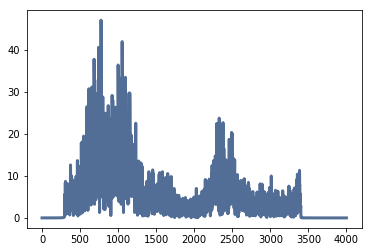

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f08f89b08d0>>
Traceback (most recent call last):
  File "/usr/lib/python3.5/wave.py", line 316, in __del__
    self.close()
  File "/usr/lib/python3.5/wave.py", line 433, in close
    if self._file:
AttributeError: 'Wave_write' object has no attribute '_file'


In [142]:
#Examine a wave's spectrum
waveFile = 'data/trainingNums/05_620a81c69b-VAD.wav'
sample = thinkdsp.read_wave(waveFile)
spectrum = sample.make_spectrum()
#spectrum.low_pass(cutoff=3400, factor=0.01)
#spectrum.high_pass(cutoff=300, factor=0.01)
spectrum.plot()

In [308]:
# create training data 
def get_longest_samples(dataPath):
    longestNumSamples = 0
    shortestNumSamples = 16000

    numSamples = []
    print('Finding longest wave file')
    for fileName in glob.iglob(os.path.join(dataPath, '*.wav')):
        print('File:', fileName)
        data, sr = sf.read(fileName)
        if len(data) > MINSIZE and len(data) < MAXSIZE:
            numSamples.append(len(data))
        assert sr == SAMPLERATE, 'wave file is not correct sample rate!'
        if len(data) < shortestNumSamples and len(data) > MINSIZE:
            shortestNumSamples = len(data)
            print('File:', fileName, shortestNumSamples)
        if len(data) > longestNumSamples and len(data) < MAXSIZE:
            longestNumSamples = len(data)
            print('File:', fileName, longestNumSamples)

    print('Number of examples:', len(numSamples))
#    numSmallSamples = 0
#    numLargeSamples = 0
#    for num in numSamples:
#        if num < 2*frameSize:
#            numSmallSamples += 1
#            print(num)
#        if num > 8000:
#            numLargeSamples += 1
#            print(num)

#    print('Longest sample = ', longestNumSamples, numLargeSamples, '/', len(numSamples))
#    print('Shortest sample = ', shortestNumSamples, numSmallSamples, '/', len(numSamples))
    return longestNumSamples

def get_frame_magnitudes(samples, numFrames, frameSize, overlap, window):
    magnitudes = np.empty((0,frameSize//2 +1))
    #print(len(samples), frameSize, overlap)
    for frame in range(numFrames):
        frameStart = frame * frameSize - frame * overlap
        # start overlap after first frame
        #if frameStart > 0:
        #    frameStart -= overlap
        #print('FrameStart:',frameStart)
        data = samples[frameStart:frameStart+frameSize]
        #print(len(data), len(window))
        frameMags = np.fft.rfft(window*data)
        #print(frameMags.shape)
        magnitudes = np.vstack((magnitudes, np.real(np.fft.rfft(window*data))))
        
    #print(magnitudes.shape)
    return magnitudes

def build_dataset(dataPath, numFrames):
    print('building dataset')
    longestNumSamples = get_longest_samples(dataPath)
    frameSize = longestNumSamples//numFrames 
    print('frame size =', frameSize)
    window = np.hanning(frameSize)
    trainingData = []
    trainingTargets = []
    print('getting magnitudes')
    for fileName in glob.iglob(os.path.join(dataPath, '*.wav')):
        print('File:', fileName)
        data, sr = sf.read(fileName)
        if MINSIZE < len(data) < MAXSIZE:
            #print(len(data))
            overlap = ((frameSize * numFrames - len(data))//(numFrames - 1)) + 1
            #trainingData = np.vstack((trainingData, get_frame_magnitudes(data, numFrames, frameSize, overlap, window)))
            trainingData.append(get_frame_magnitudes(data, numFrames, frameSize, overlap, window))
            trainingTargets.append(os.path.basename(fileName).split('_')[0])
        
    return trainingData, trainingTargets, frameSize



In [321]:
# get training data
dataPath = 'data/trainingNums'
numFrames = 4
x_train, y_train, frameSize = build_dataset(dataPath, numFrames)
x_train = np.array(x_train)
y_train = np.array(y_train)
print('Frame Size:', frameSize)
print('Num Examples:', x_train.shape[0])
#print('Training Targets:', y_train)

building dataset
Finding longest wave file
File: data/trainingNums/00_00c1b12173.wav
File: data/trainingNums/00_00c1b12173.wav 3100
File: data/trainingNums/00_00c1b12173.wav 3100
File: data/trainingNums/00_064009241a.wav
File: data/trainingNums/00_064009241a.wav 3300
File: data/trainingNums/00_0666098465.wav
File: data/trainingNums/00_07c3627a21.wav
File: data/trainingNums/00_07c3627a21.wav 3800
File: data/trainingNums/00_0a3c709caa.wav
File: data/trainingNums/00_0c447806b3.wav
File: data/trainingNums/00_0c447806b3.wav 2700
File: data/trainingNums/00_0c68680041.wav
File: data/trainingNums/00_139360572a.wav
File: data/trainingNums/00_153b017510.wav
File: data/trainingNums/00_18b81c457a.wav
File: data/trainingNums/00_18b81c457a.wav 2600
File: data/trainingNums/00_23b7ab7252.wav
File: data/trainingNums/00_2979a24a25.wav
File: data/trainingNums/00_2992ca6950.wav
File: data/trainingNums/00_2b070a32a8.wav
File: data/trainingNums/00_2b668967a8.wav
File: data/trainingNums/00_2c920018bb.wav
Fil

File: data/trainingNums/05_11425a8b64.wav
File: data/trainingNums/05_120ba72968.wav
File: data/trainingNums/05_1505477348.wav
File: data/trainingNums/05_15b37243a9.wav
File: data/trainingNums/05_17cc50bb0b.wav
File: data/trainingNums/05_18b238c5a5.wav
File: data/trainingNums/05_1cc81a9b72.wav
File: data/trainingNums/05_33b7b06973.wav
File: data/trainingNums/05_37b9393c49.wav
File: data/trainingNums/05_3b0097863c.wav
File: data/trainingNums/05_4000139189.wav
File: data/trainingNums/05_41a969b5a1.wav
File: data/trainingNums/05_4357367120.wav
File: data/trainingNums/05_46bb9bb406.wav
File: data/trainingNums/05_4955907707.wav
File: data/trainingNums/05_4c2486c280.wav
File: data/trainingNums/05_5148c81829.wav
File: data/trainingNums/05_528b06bb04.wav
File: data/trainingNums/05_548bc34833.wav
File: data/trainingNums/05_556bc8c75b.wav
File: data/trainingNums/05_5832046b50.wav
File: data/trainingNums/05_5a060b1080.wav
File: data/trainingNums/05_5c6c946098.wav
File: data/trainingNums/05_620a81c

File: data/trainingNums/09_a835344433.wav
File: data/trainingNums/09_b6b9441143.wav
File: data/trainingNums/09_b80582cb57.wav
File: data/trainingNums/09_bb80b87a26.wav
File: data/trainingNums/09_c0525492ab.wav
File: data/trainingNums/09_c282213771.wav
File: data/trainingNums/09_c29c824573.wav
File: data/trainingNums/09_c7462c7776.wav
File: data/trainingNums/09_c773421551.wav
File: data/trainingNums/09_cc504496b0.wav
File: data/trainingNums/10_0700707bb2.wav
File: data/trainingNums/10_158b34b7c0.wav
File: data/trainingNums/10_17853c2246.wav
File: data/trainingNums/10_2303986452.wav
File: data/trainingNums/10_2315bb3569.wav
File: data/trainingNums/10_24b17a888b.wav
File: data/trainingNums/10_2692a9818c.wav
File: data/trainingNums/10_3bc86684a1.wav
File: data/trainingNums/10_47b4402284.wav
File: data/trainingNums/10_49b7994420.wav
File: data/trainingNums/10_4aa683b943.wav
File: data/trainingNums/10_4c1c08b61b.wav
File: data/trainingNums/10_5089c98b04.wav
File: data/trainingNums/10_512063a

File: data/trainingNums/01_5626c47859.wav
File: data/trainingNums/01_592104b63a.wav
File: data/trainingNums/01_5bc0581a94.wav
File: data/trainingNums/01_633945447b.wav
File: data/trainingNums/01_6579802b74.wav
File: data/trainingNums/01_70a834065c.wav
File: data/trainingNums/01_71c53373a1.wav
File: data/trainingNums/01_71c6320514.wav
File: data/trainingNums/01_7211a6c315.wav
File: data/trainingNums/01_75b5583768.wav
File: data/trainingNums/01_76a52a5c93.wav
File: data/trainingNums/01_785387059c.wav
File: data/trainingNums/01_785cbc7509.wav
File: data/trainingNums/01_7869731309.wav
File: data/trainingNums/01_7880210b87.wav
File: data/trainingNums/01_79b31b3947.wav
File: data/trainingNums/01_84ab37c6b0.wav
File: data/trainingNums/01_852cb67a18.wav
File: data/trainingNums/01_8909958701.wav
File: data/trainingNums/01_9206c5cc53.wav
File: data/trainingNums/01_959ab637a7.wav
File: data/trainingNums/01_9aa445839c.wav
File: data/trainingNums/01_a6957cc00a.wav
File: data/trainingNums/01_a8024b3

File: data/trainingNums/06_a5bc7bc195.wav
File: data/trainingNums/06_a877aa7701.wav
File: data/trainingNums/06_a9c7b39c00.wav
File: data/trainingNums/06_ab3b3061b0.wav
File: data/trainingNums/06_ac23855339.wav
File: data/trainingNums/06_ac3919c1aa.wav
File: data/trainingNums/06_b13287bb23.wav
File: data/trainingNums/06_bba2a053a5.wav
File: data/trainingNums/06_c70c606945.wav
File: data/trainingNums/07_067b97c646.wav
File: data/trainingNums/07_111362cc31.wav
File: data/trainingNums/07_12276b1b20.wav
File: data/trainingNums/07_12b3950825.wav
File: data/trainingNums/07_141ba1cacc.wav
File: data/trainingNums/07_1aa587287c.wav
File: data/trainingNums/07_1b39c73c43.wav
File: data/trainingNums/07_20991867b5.wav
File: data/trainingNums/07_2363704068.wav
File: data/trainingNums/07_2375881958.wav
File: data/trainingNums/07_382b821b4c.wav
File: data/trainingNums/07_3a810c426b.wav
File: data/trainingNums/07_4197982883.wav
File: data/trainingNums/07_4223738ab5.wav
File: data/trainingNums/07_4234478

File: data/trainingNums/12_20a8192401.wav
File: data/trainingNums/12_2c091bc6b0.wav
File: data/trainingNums/12_349c10a4ac.wav
File: data/trainingNums/12_3cb2882090.wav
File: data/trainingNums/12_419bc4887b.wav
File: data/trainingNums/12_4a08511730.wav
File: data/trainingNums/12_5486152b9c.wav
File: data/trainingNums/12_54a1097386.wav
File: data/trainingNums/12_55a2a0c8b4.wav
File: data/trainingNums/12_5742a003c3.wav
File: data/trainingNums/12_61a014bca2.wav
File: data/trainingNums/12_67567b9323.wav
File: data/trainingNums/12_6813b27339.wav
File: data/trainingNums/12_6937836a0c.wav
File: data/trainingNums/12_7080112209.wav
File: data/trainingNums/12_81c528ab57.wav
File: data/trainingNums/12_825b07306a.wav
File: data/trainingNums/12_9193130ca7.wav
File: data/trainingNums/12_9727637563.wav
File: data/trainingNums/12_973c327439.wav
File: data/trainingNums/12_a21cc38502.wav
File: data/trainingNums/12_a398641269.wav
File: data/trainingNums/12_a41760c39c.wav
File: data/trainingNums/12_a545aa9

In [324]:
def model(batchSize, numNeurons, outputs, freqBins):
    regVal = 0.0001
    x_in = Input(batch_shape=(batchSize, 4, freqBins))
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x_in)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(numNeurons, activation='relu', kernel_regularizer=regularizers.l2(regVal), bias_regularizer=regularizers.l2(regVal))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)    
    x = Dense(outputs, activation='softmax', kernel_regularizer=regVal, bias_regularizer=regVal)(x)
    model = Model(inputs=[x_in], outputs=[x])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

batchSize = 16
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.05, shuffle=True )
numTrainExamples = batchSize * (len(x_train)//batchSize)
x_train = x_train[0:numTrainExamples,:,:]
y_train = y_train[0:numTrainExamples]
numValidExamples = batchSize * (len(x_valid)//batchSize)
x_valid = x_valid[0:numValidExamples,:,:]
y_valid = y_valid[0:numValidExamples]
print('Training on', numTrainExamples, 'examples')
print('Validating on', numValidExamples, 'examples')

freqBins = frameSize//2 + 1
epochs = 1000
numNeurons = 100
outputs = 13 # 0-12
AudioWords = model(batchSize, numNeurons, outputs, freqBins)
AudioWords.summary()

model_history = AudioWords.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batchSize, epochs=epochs)

Training on 480 examples
Validating on 16 examples


ValueError: ('Could not interpret regularizer identifier:', 0.0001)

In [148]:
def clip_wave(fileName):
    samples, sample_rate = sf.read(fileName )
    print("number of samples:", len(samples))

    # find largest cluster of audio and grab the samples
    clippedSamples = clip_audio(samples)

    # write clipped audio to file
    #clippedFileName = os.path.join(clippedAudioPath, os.path.basename(fileName))
    clippedFileName = fileName.replace('.wav', 'clipped.wav')
    sf.write(clippedFileName, clippedSamples, SAMPLERATE, subtype='PCM_16')
    print(fileName,' clipped and saved as ',clippedFileName)
    

In [186]:
fileName = 'data/trainingNums/00_0666098465-VAD.wav'
fileName = 'data/exps/00_0a3c709caa.wav'
clip_wave(fileName)

number of samples: 16346
avg: 0.052902699669749954
frame avg: 0.01625274658203125
frame avg: 0.00538909912109375
frame avg: 0.00462188720703125
frame avg: 0.0023785400390625
frame avg: 0.00160797119140625
frame avg: 0.0013726806640625
frame avg: 0.0010443115234375
frame avg: 0.00091339111328125
frame avg: 0.0007440185546875
frame avg: 0.0006494140625
frame avg: 0.0006182861328125
frame avg: 0.00054779052734375
frame avg: 0.000509033203125
frame avg: 0.0005194091796875
frame avg: 0.0004815673828125
frame avg: 0.000465087890625
frame avg: 0.00042388916015625
frame avg: 0.0004302978515625
frame avg: 0.0003863525390625
frame avg: 0.00034393310546875
frame avg: 0.0003192138671875
frame avg: 0.00037261962890625
frame avg: 0.00070892333984375
frame avg: 0.0159033203125
frame avg: 0.01576934814453125
frame avg: 0.00220916748046875
frame avg: 0.002239990234375
frame avg: 0.00155517578125
frame avg: 0.0014935302734375
frame avg: 0.00127349853515625
frame avg: 0.00208160400390625
frame avg: 0.002

In [196]:
def get_averages(samples, frameSize):
    averages = []
    for frame in range(0,len(samples), frameSize):
        averages.append(np.average(np.absolute(samples[frame:frame+frameSize])))

    return averages

def find_clusters(samples, averages, target, frameSize):
    startIdx = None
    endIdx = None
    clusters = []
    for idx, frame in enumerate(range(0,len(samples), frameSize)):
        #print('frame avg:', averages[idx])
        if averages[idx] > target and not startIdx:
            startIdx = idx
        if startIdx and not endIdx:
            if averages[idx] < target:
                endIdx = idx
        if startIdx and endIdx:
            clusters.append((startIdx,endIdx))
            startIdx = None
            endIdx = None

    # incase last frame is above average
    if startIdx != None and endIdx == None:
        endIdx = idx
        clusters.append((startIdx,endIdx))
        
    #print(averages[idx])
    return clusters

def find_longest_cluster(clusters):
    longestCluster = 0
    longestClusterSize = 0
    for cluster in clusters:
        clusterSize = cluster[1]-cluster[0]
        if clusterSize > longestClusterSize:
            longestClusterSize = clusterSize
            longestCluster = cluster

    return longestCluster

def clip_audio(samples):

    frameSize = 100
    averages = get_averages(samples, frameSize)
    target = np.average(averages)/2     # threshold, assume below this level is backround noise

    #print('target avg:', target)
    # find all audio clusters above target threshold
    clusters = find_clusters(samples, averages, target, frameSize)

    #for cluster in clusters:
    #    print(cluster[0]*frameSize, cluster[1]*frameSize)
    #print('Clusters:', clusters)
    
    # find longest audio cluster
    longestCluster = find_longest_cluster(clusters)
    
    print('Clipping samples', longestCluster[0]*frameSize, longestCluster[1]*frameSize)

    return samples[longestCluster[0]*frameSize:longestCluster[1]*frameSize+frameSize]

def clip_waves(rawAudioPath, clippedAudioPath):
    for fileName in glob.iglob(os.path.join(rawAudioPath, '*.wav')):
        print('File:', fileName)
        samples, sample_rate = sf.read(fileName )
        print("number of samples:", len(samples))

        # find largest cluster of audio and grab the samples
        clippedSamples = clip_audio(samples)

        # write clipped audio to file
        clippedFileName = os.path.join(clippedAudioPath, os.path.basename(fileName))
        sf.write(clippedFileName, clippedSamples, SAMPLERATE, subtype='PCM_16')
        print(fileName,' clipped and saved as ',clippedFileName)



In [177]:
trainingData = 'data/trainingNums'
clip_waves(trainingData, trainingData)

File: data/trainingNums/00_00c1b12173-VAD.wav
number of samples: 2400
avg: 0.22391043345133463
frame avg: 0.1097100830078125
frame avg: 0.18750579833984374
frame avg: 0.297396240234375
frame avg: 0.30315216064453127
frame avg: 0.3071307373046875
frame avg: 0.28498870849609376
frame avg: 0.30393157958984374
frame avg: 0.288038330078125
frame avg: 0.2594140625
frame avg: 0.22300445556640625
frame avg: 0.22907135009765625
frame avg: 0.2091796875
frame avg: 0.23687255859375
frame avg: 0.241591796875
frame avg: 0.294107666015625
frame avg: 0.22062408447265625
frame avg: 0.23472076416015625
frame avg: 0.23862030029296874
frame avg: 0.2198382568359375
frame avg: 0.22629974365234376
frame avg: 0.17473541259765624
frame avg: 0.1378302001953125
frame avg: 0.1009283447265625
frame avg: 0.0451580810546875
Clusters: [(2, 9), (10, 11), (12, 15), (16, 18), (19, 20)]
Clipping samples 200 900
data/trainingNums/00_00c1b12173-VAD.wav  clipped and saved as  data/trainingNums/00_00c1b12173-VAD.wav
File: da

frame avg: 0.15264068603515624
frame avg: 0.141529541015625
frame avg: 0.096192626953125
frame avg: 0.08359893798828125
frame avg: 0.074022216796875
frame avg: 0.056549072265625
frame avg: 0.05508575439453125
frame avg: 0.02943572998046875
Clusters: [(2, 10), (11, 21)]
Clipping samples 1100 2100
data/trainingNums/00_2b668967a8-VAD.wav  clipped and saved as  data/trainingNums/00_2b668967a8-VAD.wav
File: data/trainingNums/00_2c920018bb-VAD.wav
number of samples: 1900
avg: 0.25077341180098683
frame avg: 0.1588140869140625
frame avg: 0.31201202392578126
frame avg: 0.3742483520507813
frame avg: 0.416966552734375
frame avg: 0.33149658203125
frame avg: 0.33642791748046874
frame avg: 0.2978323364257813
frame avg: 0.25430145263671877
frame avg: 0.273504638671875
frame avg: 0.258656005859375
frame avg: 0.1957159423828125
frame avg: 0.2404412841796875
frame avg: 0.1999456787109375
frame avg: 0.16265167236328126
frame avg: 0.17386077880859374
frame avg: 0.2642709350585937
frame avg: 0.189134216308

data/trainingNums/00_66a1550b08-VAD.wav  clipped and saved as  data/trainingNums/00_66a1550b08-VAD.wav
File: data/trainingNums/00_6776c0b596-VAD.wav
number of samples: 2100
avg: 0.19674098423549108
frame avg: 0.0957757568359375
frame avg: 0.12038055419921875
frame avg: 0.17595611572265624
frame avg: 0.28593963623046875
frame avg: 0.4239004516601563
frame avg: 0.433885498046875
frame avg: 0.349342041015625
frame avg: 0.30819427490234375
frame avg: 0.2484222412109375
frame avg: 0.20798736572265625
frame avg: 0.1989422607421875
frame avg: 0.19672943115234376
frame avg: 0.1875927734375
frame avg: 0.14815704345703126
frame avg: 0.13064178466796875
frame avg: 0.0962835693359375
frame avg: 0.08400360107421875
frame avg: 0.1401666259765625
frame avg: 0.145123291015625
frame avg: 0.08294281005859375
frame avg: 0.07119354248046875
Clusters: [(3, 11)]
Clipping samples 300 1100
data/trainingNums/00_6776c0b596-VAD.wav  clipped and saved as  data/trainingNums/00_6776c0b596-VAD.wav
File: data/trainin

TypeError: 'int' object is not subscriptable

8000
1200
240
(121,)


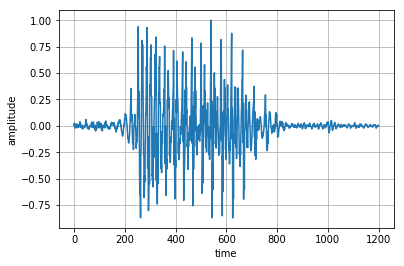

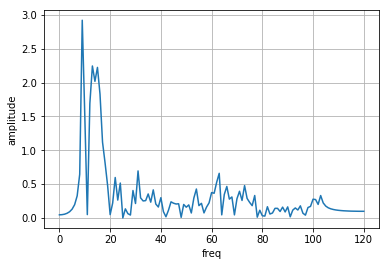

In [237]:
# load a wave, plot and play
#fileName = 'data/filteredNumbers/01_aa570a1398.wav' 
fileName = 'data/trainingNums/06_1507906720.wav'
#fileName = 'data/trainingNums/00_0666098465-VADclipped.wav'
#fileName = 'data/exps/00_0a3c709caaclipped.wav'
data, sample_rate = sf.read(fileName)
print(sample_rate)
print(len(data))
duration = len(data)//5
print(duration)

plt.figure()
plt.plot(data)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

mags = abs(np.real(np.fft.rfft(data[:duration])))
print(mags.shape)
plt.figure()
plt.plot(mags)
plt.xlabel('freq')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

#clippedSamples = clip_audio(data)
Audio(data, rate=sample_rate)

In [3]:
path = 'data/numbers/'
SAMPLE_RATE = 8000

for fileName in glob.iglob(path + '*wav'):
    print('File:', fileName)
    data, sample_rate = sf.read(fileName )
    print("number of samples:", len(data))

File: data/numbers/00_064009241a.wav
number of samples: 12404
File: data/numbers/00_0666098465.wav
number of samples: 16326
File: data/numbers/00_07c3627a21.wav
number of samples: 15702
File: data/numbers/00_139360572a.wav
number of samples: 16326
File: data/numbers/00_2992ca6950.wav
number of samples: 16422
File: data/numbers/00_2b668967a8.wav
number of samples: 12309
File: data/numbers/00_3cb3738708.wav
number of samples: 16326
File: data/numbers/00_5738176457.wav
number of samples: 16326
File: data/numbers/00_6057878849.wav
number of samples: 15702
File: data/numbers/00_66a1550b08.wav
number of samples: 12404
File: data/numbers/00_6776c0b596.wav
number of samples: 8322
File: data/numbers/00_7899937504.wav
number of samples: 16384
File: data/numbers/00_843b1a54a5.wav
number of samples: 16423
File: data/numbers/00_b862b57c44.wav
number of samples: 16347
File: data/numbers/00_cb3a68216a.wav
number of samples: 16326
File: data/numbers/01_0682422500.wav
number of samples: 12309
File: dat

number of samples: 15702
File: data/numbers/10_c33b598001.wav
number of samples: 8322
File: data/numbers/11_0a78649368.wav
number of samples: 16384
File: data/numbers/11_1a80281987.wav
number of samples: 16326
File: data/numbers/11_2324909063.wav
number of samples: 16422
File: data/numbers/11_372b227c2b.wav
number of samples: 8322
File: data/numbers/11_590c23a2c0.wav
number of samples: 15604
File: data/numbers/11_5a13b80067.wav
number of samples: 15702
File: data/numbers/11_5c12c4c5c2.wav
number of samples: 15604
File: data/numbers/11_77cc6607ac.wav
number of samples: 16326
File: data/numbers/11_c431796a8b.wav
number of samples: 8322
File: data/numbers/12_349c10a4ac.wav
number of samples: 16347
File: data/numbers/12_419bc4887b.wav
number of samples: 16326
File: data/numbers/12_4a08511730.wav
number of samples: 8322
File: data/numbers/12_54a1097386.wav
number of samples: 8322
File: data/numbers/12_5742a003c3.wav
number of samples: 16422
File: data/numbers/12_a21cc38502.wav
number of sam

0.0


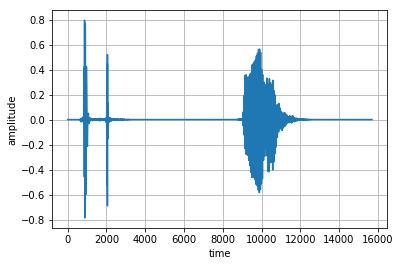

In [42]:
#data, sample_rate = sf.read('data/numbers/02_b4a02c3c00.wav' )
data, sample_rate = sf.read('data/numbers/00_6057878849.wav' )
print(min(abs(data)))
plt.figure()
plt.plot(data)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

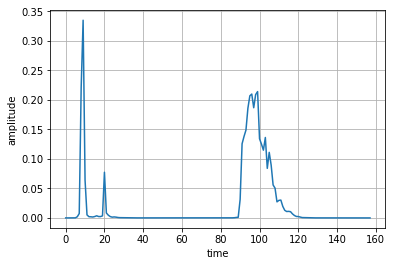

In [40]:
averages = []
frameSize = 100
for frame in range(0,len(data), frameSize):
    averages.append(np.average(np.absolute(data[frame:frame+frameSize])))
#print(averages)
#print(np.average(averages))
avg = np.average(averages)
plt.figure()
plt.plot(averages)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)

[(8, 11), (20, 21), (90, 114), (115, 116)]
(115, 116)
start idx: 9000 end idx: 11400


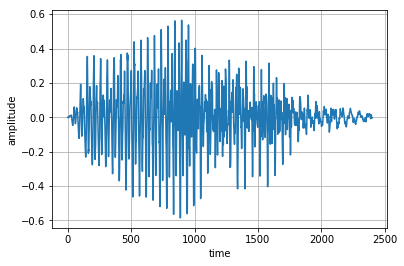

In [41]:
startIdx = None
endIdx = None
clusters = []
for idx, frame in enumerate(range(0,len(data), step)):
    if averages[idx] > avg/2 and not startIdx:
        startIdx = idx
    if startIdx and not endIdx:
        if averages[idx] < avg/2:
            endIdx = idx
    if startIdx and endIdx:
        clusters.append((startIdx,endIdx))
        startIdx = None
        endIdx = None
        
print(clusters) 
# find largest cluster
largest_cluster = 0
largest_cluster_size = 0
for cluster in clusters:
    cluster_size = cluster[1]-cluster[0]
    if cluster_size > largest_cluster_size:
        largest_cluster_size = cluster_size
        largest_cluster = cluster
        
clippedData = data[largest_cluster[0]*frameSize:largest_cluster[1]*frameSize]
        
    
print(cluster)
print('start idx:', largest_cluster[0]*frameSize, 'end idx:',largest_cluster[1]*frameSize)
#newData = data[startIdx*100:endIdx*100]
plt.figure()
plt.plot(clippedData)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.grid(True)
#plays audio
#ipd.Audio(clippedData, rate=SAMPLE_RATE)
sf.write('output.wav', clippedData, SAMPLE_RATE, subtype='PCM_16')

(8164,)
[0.29718018 0.77803293 0.15939209 ... 0.00657533 0.0049441  0.00476074]


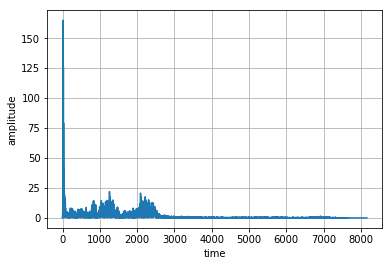

In [45]:
mags = abs(np.real(np.fft.rfft(data)))
print(mags.shape)
print(mags)
plt.figure()
plt.plot(mags)
plt.xlabel('time')
plt.ylabel('amplitude')
#plt.yscale('log')
plt.grid(True)